In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data and merge the train and test with features

coded_id = pd.read_csv(r"C:\Users\thaka\Music\college\5. Sem 5\btp\Model\data\coded_ids.csv")
features = pd.read_csv(r"C:\Users\thaka\Music\college\5. Sem 5\btp\Model\data\features.csv")
users = pd.merge(features, coded_id, on='user_id', how='left')

train = pd.read_csv(r"C:\Users\thaka\Music\college\5. Sem 5\btp\Model\data\coded_ids_labels_train.csv")
test = pd.read_csv(r"C:\Users\thaka\Music\college\5. Sem 5\btp\Model\data\coded_ids_labels_test.csv")
train = pd.merge(users, train, on='coded_id', how='right')
test = pd.merge(users, test, on='coded_id', how='right')

In [3]:
train.shape

(686, 147)

In [4]:
test.shape

(81, 147)

In [5]:
#cleaning train dataset

#remove columns with na values
nacolumns = train.columns[train.isna().any()].tolist()
train.drop(columns = nacolumns,inplace=True)
train.dropna(axis=0,inplace=True)

#remove unwanted category columns like time and IDs
unwanted = ["default_profile","default_profile_image","avg_intertweet_times","date_newest_tweet","lang","min_intertweet_times","std_nb_symbols_per_tweet","std_nb_symbols_per_word_in_the_tweet","date_oldest_tweet","max_intertweet_times","max_nb_symbols_per_tweet","max_nb_symbols_per_word_in_the_tweet","std_intertweet_times","user_id","coded_id"]
train.drop(columns=unwanted,inplace=True)

#remove columns like 
allzero_cols = list(train.loc[:,(train==0).all()].columns)
train.drop(columns=allzero_cols,inplace=True)

In [6]:
#cleaning test dataset

#remove columns with na values
nacolumns = test.columns[test.isna().any()].tolist()
test.drop(columns = nacolumns,inplace=True)
test.dropna(axis=0,inplace=True)

#remove unwanted category columns like time and IDs
unwanted = ["default_profile","default_profile_image","avg_intertweet_times","date_newest_tweet","lang","min_intertweet_times","std_nb_symbols_per_tweet","std_nb_symbols_per_word_in_the_tweet","date_oldest_tweet","max_intertweet_times","max_nb_symbols_per_tweet","max_nb_symbols_per_word_in_the_tweet","std_intertweet_times","user_id","coded_id"]
test.drop(columns=unwanted,inplace=True)

#remove columns like 
allzero_cols = list(test.loc[:,(test==0).all()].columns)
test.drop(columns=allzero_cols,inplace=True)

In [7]:
#split data into x features and labels
x = train.iloc[:,:124]

#normalizing the numerical features
scale = StandardScaler()
x = scale.fit_transform(x)
test = scale.fit_transform(test)

y = train.label

In [8]:
x.shape

(686, 124)

In [9]:
y.value_counts()

label
0    568
1    118
Name: count, dtype: int64

In [10]:
#train test (validation) split
x_train, x_test, y_train, y_test = train_test_split(x,y ,stratify=y, test_size=0.15,random_state=1)


In [11]:
#function for performing grid search

def grid_search(model,params):
  skf = StratifiedKFold(n_splits=10)
  gs = GridSearchCV(model, cv=skf, param_grid=params, return_train_score=True)
  gs.fit(x_train, y_train)
  print("best params = ",gs.best_params_)
  print("best score =",gs.best_score_)

In [12]:
#naives bayes
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
params = {"var_smoothing":[1,0.1,1e-2]}

grid_search(model,params)

best params =  {'var_smoothing': 0.1}
best score = 0.9176504967855055


In [13]:
#naives bayes test
model = GaussianNB(var_smoothing=0.1)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 0.9228
              precision    recall  f1-score   support

           0       0.99      0.88      0.93        85
           1       0.63      0.94      0.76        18

    accuracy                           0.89       103
   macro avg       0.81      0.91      0.84       103
weighted avg       0.92      0.89      0.90       103



In [14]:
#knn

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
params = {"n_neighbors":[i for i in range(1,20)]}

grid_search(model,params)

best params =  {'n_neighbors': 3}
best score = 0.950292226767972


In [15]:
#knn test

model = KNeighborsClassifier(n_neighbors=3)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 0.9691
              precision    recall  f1-score   support

           0       0.94      0.99      0.97        85
           1       0.93      0.72      0.81        18

    accuracy                           0.94       103
   macro avg       0.94      0.86      0.89       103
weighted avg       0.94      0.94      0.94       103



In [16]:
#svm

from sklearn.svm import SVC

model = SVC()
params = {"C":[0.1,1,10],
          "kernel":["linear", "poly", "rbf", "sigmoid"]}
grid_search(model,params)

best params =  {'C': 10, 'kernel': 'poly'}
best score = 0.9571011104617183


In [17]:
#decision tree
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
params = {"criterion":["gini","entropy"],
          "max_depth":range(1,10),
          "min_samples_split":range(2,10),
          "min_samples_leaf":range(1,5)}
grid_search(model,params)

best params =  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 9}
best score = 0.955406195207481


In [18]:
#random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid_search(model,params)

best params =  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}
best score = 0.9622443015780243


In [ ]:
!pip install keras
!pip install tensorflow
!pip install scikeras

In [19]:
#MLP
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder

model = Sequential()
model.add(Dense(50, input_dim=124, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=10)

Epoch 1/10
59/59 [==============================] - 1s 2ms/step - loss: 0.3512 - accuracy: 0.8559
Epoch 2/10
59/59 [==============================] - 0s 2ms/step - loss: 0.1617 - accuracy: 0.9417
Epoch 3/10
59/59 [==============================] - 0s 2ms/step - loss: 0.1114 - accuracy: 0.9605
Epoch 4/10
59/59 [==============================] - 0s 2ms/step - loss: 0.0877 - accuracy: 0.9691
Epoch 5/10
59/59 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.9794
Epoch 6/10
59/59 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.9777
Epoch 7/10
59/59 [==============================] - 0s 2ms/step - loss: 0.0550 - accuracy: 0.9828
Epoch 8/10
59/59 [==============================] - 0s 2ms/step - loss: 0.0494 - accuracy: 0.9846
Epoch 9/10
59/59 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9880
Epoch 10/10
59/59 [==============================] - 0s 2ms/step - loss: 0.0470 - accuracy: 0.9880


In [20]:

#MLP
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import LabelEncoder

model = Sequential()
model.add(Dense(50, input_dim=124, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x, y, epochs=10, batch_size=10)

Epoch 1/10
69/69 [==============================] - 1s 2ms/step - loss: 0.3313 - accuracy: 0.8776
Epoch 2/10
69/69 [==============================] - 0s 2ms/step - loss: 0.1418 - accuracy: 0.9563
Epoch 3/10
69/69 [==============================] - 0s 2ms/step - loss: 0.0997 - accuracy: 0.9665
Epoch 4/10
69/69 [==============================] - 0s 2ms/step - loss: 0.0800 - accuracy: 0.9694
Epoch 5/10
69/69 [==============================] - 0s 2ms/step - loss: 0.0663 - accuracy: 0.9767
Epoch 6/10
69/69 [==============================] - 0s 2ms/step - loss: 0.0564 - accuracy: 0.9810
Epoch 7/10
69/69 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.9825
Epoch 8/10
69/69 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9840
Epoch 9/10
69/69 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.9883
Epoch 10/10
69/69 [==============================] - 0s 2ms/step - loss: 0.0331 - accuracy: 0.9927


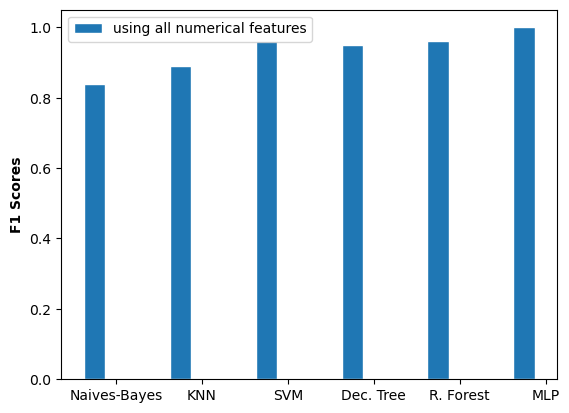

In [21]:

# set width of bar
import matplotlib.pyplot as plt
barWidth = 0.25
 


# set height of bar
bars1 = [0.84,0.89,0.96,0.95,0.96,1.00]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='using all numerical features')

# Add xticks on the middle of the group bars
plt.ylabel('F1 Scores', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Naives-Bayes', 'KNN', 'SVM', 'Dec. Tree', 'R. Forest', "MLP"])
 
# Create legend & Show graphic
plt.legend()
plt.savefig("f1score", bbox_inches='tight',dpi = 200)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 686 samples in 0.001s...
[t-SNE] Computed neighbors for 686 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 686 / 686
[t-SNE] Mean sigma: 3.280809
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.948265
[t-SNE] KL divergence after 300 iterations: 1.093785


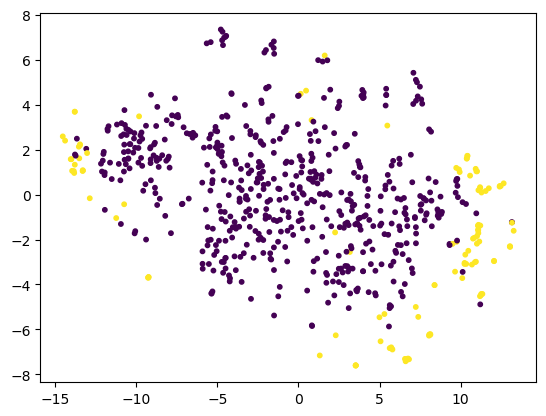

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)

a = tsne_results[:,0]
b = tsne_results[:,1]
plt.scatter(a,b,c=y,s=10)
# print(a)
# print(b)


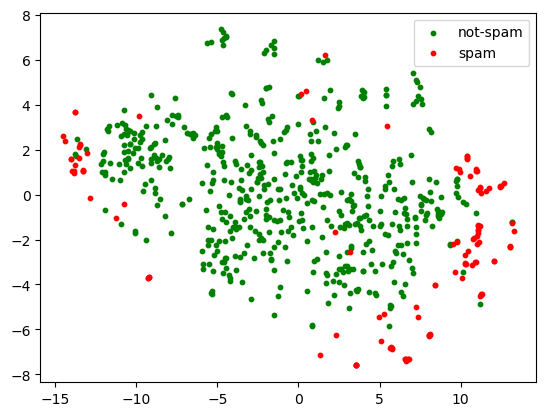

In [23]:
df = pd.DataFrame()
df["a"] = a
df["b"] = b
df["y"] = y

aa = df[df.y==0]
bb = df[df.y==1]

plt.scatter(aa.a,aa.b,c="green",s=10,label="not-spam")
plt.scatter(bb.a,bb.b,c="red",s=10,label="spam")
plt.legend()
plt.savefig("tsne", bbox_inches='tight',dpi = 200)